In [12]:
import tensorflow as tf
import os
import random
import numpy as np
 
from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import config
from utils import *
from keras.preprocessing.image import ImageDataGenerator
from seg_train_generator import *

seed = 42
np.random.seed = seed

IMG_WIDTH = None
IMG_HEIGHT = None
IMG_CHANNELS = 3

do = 0.1
iteration = 2
kernel = 32

#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(kernel, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(kernel, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(kernel * 2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(kernel * 2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(kernel * 4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(kernel * 4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(kernel * 8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(kernel * 8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(kernel * 16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(kernel * 16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(kernel * 8, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(kernel * 8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(kernel * 8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(kernel * 4, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(kernel * 4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(kernel * 4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(kernel * 2, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(kernel * 2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(kernel * 2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(kernel, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(kernel, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(kernel, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)


pt_conv1a = tf.keras.layers.Conv2D(32, (3, 3), padding='same')
pt_activation1a = tf.keras.layers.ReLU()
pt_dropout1a = tf.keras.layers.Dropout(do)
pt_conv1b = tf.keras.layers.Conv2D(32, (3, 3), padding='same')
pt_activation1b = tf.keras.layers.ReLU()
pt_dropout1b = tf.keras.layers.Dropout(do)
pt_pooling1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))

pt_conv2a = tf.keras.layers.Conv2D(32 * 2, (3, 3), padding='same')
pt_activation2a = tf.keras.layers.ReLU()
pt_dropout2a = tf.keras.layers.Dropout(do)
pt_conv2b = tf.keras.layers.Conv2D(32 * 2, (3, 3), padding='same')
pt_activation2b = tf.keras.layers.ReLU()
pt_dropout2b = tf.keras.layers.Dropout(do)
pt_pooling2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))

pt_conv3a = tf.keras.layers.Conv2D(32 * 4, (3, 3), padding='same')
pt_activation3a = tf.keras.layers.ReLU()
pt_dropout3a = tf.keras.layers.Dropout(do)
pt_conv3b = tf.keras.layers.Conv2D(32 * 4, (3, 3), padding='same')
pt_activation3b = tf.keras.layers.ReLU()
pt_dropout3b = tf.keras.layers.Dropout(do)

pt_tranconv8 = tf.keras.layers.Conv2DTranspose(32 * 2, (2, 2), strides=(2, 2), padding='same')
pt_conv8a = tf.keras.layers.Conv2D(32 * 2, (3, 3), padding='same')
pt_activation8a = tf.keras.layers.ReLU()
pt_dropout8a = tf.keras.layers.Dropout(do)
pt_conv8b = tf.keras.layers.Conv2D(32 * 2, (3, 3), padding='same')
pt_activation8b = tf.keras.layers.ReLU()
pt_dropout8b = tf.keras.layers.Dropout(do)

pt_tranconv9 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')
pt_conv9a = tf.keras.layers.Conv2D(32, (3, 3), padding='same')
pt_activation9a = tf.keras.layers.ReLU()
pt_dropout9a = tf.keras.layers.Dropout(do)
pt_conv9b = tf.keras.layers.Conv2D(32, (3, 3), padding='same')
pt_activation9b = tf.keras.layers.ReLU()
pt_dropout9b = tf.keras.layers.Dropout(do)

conv9s = [c9]
outs = []
a_layers = [c1]
for iteration_id in range(iteration):
    out = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid', name=f'out1{iteration_id + 1}')(conv9s[-1])
    outs.append(out)

    conv1 = pt_dropout1a(pt_activation1a(pt_conv1a(conv9s[-1])))
    conv1 = pt_dropout1b(pt_activation1b(pt_conv1b(conv1)))
    a_layers.append(conv1)
    conv1 = tf.keras.layers.concatenate(a_layers, axis=3)
    conv1 = tf.keras.layers.Conv2D(32, (1, 1), padding='same')(conv1)
    pool1 = pt_pooling1(conv1)

    conv2 = pt_dropout2a(pt_activation2a(pt_conv2a(pool1)))
    conv2 = pt_dropout2b(pt_activation2b(pt_conv2b(conv2)))
    pool2 = pt_pooling2(conv2)

    conv3 = pt_dropout3a(pt_activation3a(pt_conv3a(pool2)))
    conv3 = pt_dropout3b(pt_activation3b(pt_conv3b(conv3)))

    up8 = tf.keras.layers.concatenate([pt_tranconv8(conv3), conv2], axis=3)
    conv8 = pt_dropout8a(pt_activation8a(pt_conv8a(up8)))
    conv8 = pt_dropout8b(pt_activation8b(pt_conv8b(conv8)))

    up9 = tf.keras.layers.concatenate([pt_tranconv9(conv8), conv1], axis=3)
    conv9 = pt_dropout9a(pt_activation9a(pt_conv9a(up9)))
    conv9 = pt_dropout9b(pt_activation9b(pt_conv9b(conv9)))

    conv9s.append(conv9)

seg_final_out = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid', name='seg_final_out')(conv9)
outs.append(seg_final_out)

 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[seg_final_out])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [10]:

################################
#Modelcheckpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint('model_for_seg_best.h5', verbose=1, save_best_only=True, monitor='accuracy')

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=10, monitor='accuracy'),
        tf.keras.callbacks.TensorBoard(log_dir='logs'),
        checkpoint]


In [3]:


# convert_ppm_to_png(config.TRAIN_DIR_SEG, f'{config.TRAIN_DIR_SEG}/png/')
# convert_ppm_to_png(config.LABEL_DIR_SEG, f'{config.LABEL_DIR_SEG}/png/')

image_dir = config.TRAIN_DIR_SEG# directory with clean images
label_dir = config.LABEL_DIR_SEG # directory with noisy images file names same as filenames in clean dir
shuffle = False # if True shuffles the dataframe
df = create_df(image_dir, label_dir ,shuffle) # create a dataframe with columns 'images' , 'labels'
                                            # where labels are the noisy images
                                            


In [4]:
train_split = .8 # use 80% of files for training
test_split = .1  # use 10% for test, automatically sets validation split at 1-train_split-test_split
batch_size = 5 # set batch_size
height = 256 # set image height for generator output images and labels
width = 256 # set image width for generator output images and labels
channels = 3 # set number of channel in images
image_shape = (height, width) 
rescale = 1/255  # set value to rescale image pixels


In [5]:
gen = jpgen(df, train_split=train_split, test_split=test_split) # create instance of generator class
tr_gen_len = gen.tr_gen_len
test_gen_len = gen.test_gen_len
valid_gen_len = gen.valid_gen_len   
test_filenames = gen.test_gen_filenames # names of test file paths used for training 
train_steps = tr_gen_len//batch_size #  use this value in for steps_per_epoch in model.fit
valid_steps = valid_gen_len//batch_size # use this value for validation_steps in model.fit
test_steps = test_gen_len//batch_size  # use this value for steps in model.predict

# instantiate generators
train_gen = gen.flow(batch_size=batch_size, image_shape=image_shape, rescale=rescale, shuffle=False, subset='training', random_factor=0.7)
valid_gen = gen.flow(batch_size=batch_size, image_shape=image_shape, rescale=rescale, shuffle=False, subset='valid', random_factor=0.7)
test_gen = gen.flow(batch_size=batch_size, image_shape=image_shape, rescale=rescale, shuffle=False, subset='test', random_factor=0.7)


In [13]:

results = model.fit(train_gen, batch_size=5, epochs=50, callbacks=callbacks, steps_per_epoch=50*train_steps, validation_steps=valid_steps, validation_data=valid_gen,  shuffle=True) # 20 num de fotos, 5 batch

# predictions=model.predict(test_gen, steps=test_steps)

# print(predictions)

Epoch 1/50
150/150 [==============================] - ETA: 0s - loss: 0.3066 - accuracy: 0.8976 
Epoch 1: accuracy improved from -inf to 0.89759, saving model to model_for_seg_best.h5
150/150 [==============================] - 1564s 10s/step - loss: 0.3066 - accuracy: 0.8976
Epoch 2/50
150/150 [==============================] - ETA: 0s - loss: 0.1380 - accuracy: 0.9224 
Epoch 2: accuracy improved from 0.89759 to 0.92238, saving model to model_for_seg_best.h5
150/150 [==============================] - 1546s 10s/step - loss: 0.1380 - accuracy: 0.9224
Epoch 3/50
150/150 [==============================] - ETA: 0s - loss: 0.1119 - accuracy: 0.9301 
Epoch 3: accuracy improved from 0.92238 to 0.93009, saving model to model_for_seg_best.h5
150/150 [==============================] - 1538s 10s/step - loss: 0.1119 - accuracy: 0.9301
Epoch 4/50
150/150 [==============================] - ETA: 0s - loss: 0.0920 - accuracy: 0.9358 
Epoch 4: accuracy improved from 0.93009 to 0.93576, saving model to m

KeyboardInterrupt: 

In [ ]:
model.save_weights('./output/teste_promissor_2_22_02')
model.save('./output/model_teste_promissor_2_22_02')

INFO:tensorflow:Assets written to: ./output/model_teste_promissor_2_13_02\assets


INFO:tensorflow:Assets written to: ./output/model_teste_promissor_2_13_02\assets


In [8]:
model.save('my_model_13-02.h5')

In [39]:
img = tf.keras.preprocessing.image.load_img('./datasets/PROCESSED/TESTE/1/parte_3_1493.png', target_size=(256,256))
img_tensor = tf.keras.preprocessing.image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

In [41]:
img_tensor.shape

(1, 256, 256, 3)

In [50]:
image = cv2.imread('./datasets/PROCESSED/TESTE/1/parte_3_1493.png')

In [51]:

image = cv2.imread('./datasets/PROCESSED/TESTE/1/parte_3_1493.png')

def gaussian_filter(image):
    sigmaX = 10
    return cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0,0), sigmaX), -4, 128)

image = gaussian_filter(image)
image = cv2.resize(image, (256,256))
img_tensor = np.expand_dims(image, axis=0)
predictions = model.predict(image_tensor)

In [52]:
image = gaussian_filter(image)


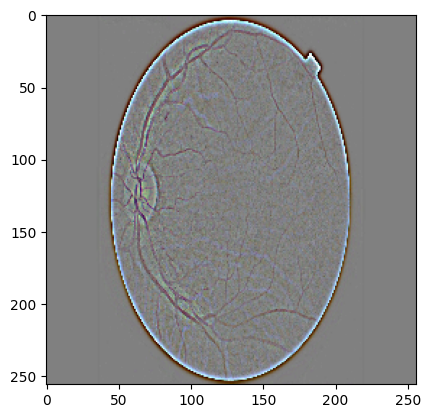

In [58]:
plt.imshow(image)
plt.show()

In [59]:
image = cv2.resize(image, (256,256))

In [64]:
img_tensor = np.expand_dims(image, axis=0)
img_tensor.shape


(1, 256, 256, 3)

In [66]:
image_tensor_norm = cv2.normalize(img_tensor, None, 0, 1.0,cv2.NORM_MINMAX, dtype=cv2.CV_32F)


In [ ]:
plt.imshow(image_tensor_norm)
plt.show()

In [35]:
image = gaussian_filter(image)

In [31]:
input_image = np.array(image)

In [70]:
predictions = model.predict(image_tensor_norm)

1/1 [==============================] - 0s 360ms/step


In [19]:
len(predictions)

1

In [71]:
output_2d = predictions.squeeze()
pred = 255. * (predictions - np.min(predictions)) / (np.max(predictions) - np.min(predictions))
#cv2.imwrite("teste.png", pred.squeeze())

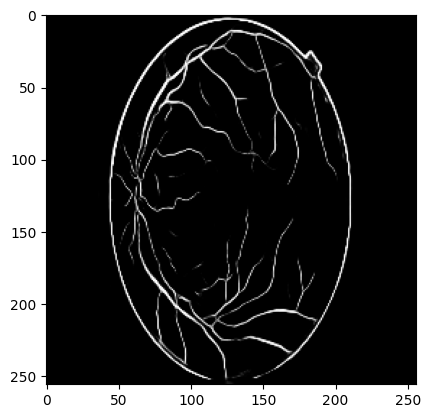

: 

In [72]:
output_2d = predictions.squeeze()
plt.imshow(output_2d, cmap='gray')
plt.show()